In [ ]:
#| default_exp library_size

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
from dgrec.utils import parse_genotypes, str_to_mut
import os
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from typing import Dict, Any, List, Callable
import numpy as np
from scipy.stats import linregress
from scipy.integrate import quad

import matplotlib.pyplot as plt

In [ ]:
#| export
def find_best_breakpoint(counts: np.ndarray) -> tuple[int, float, float]:
    """
    Finds the optimal breakpoint B for a hybrid power-law distribution.

    This function iterates through possible breakpoints and performs a linear
    regression on the log-log plot of the tail of the distribution (rank vs. probability).
    The optimal breakpoint is chosen as the one that maximizes the R-squared
    value of the linear fit, indicating the point where the power-law
    behavior is most pronounced.

    Args:
        counts (np.ndarray): An array of UMI counts for each observed genotype,
                             sorted in descending order.

    Returns:
        tuple[int, float, float]: A tuple containing:
            - best_b (int): The estimated optimal breakpoint B.
            - best_alpha (float): The estimated power-law exponent alpha for the tail.
            - best_intercept (float): The intercept from the log-log linear regression.
    """
    n_total = np.sum(counts)
    m_observed = len(counts)
    if m_observed < 20:
        print("Warning: Low number of observed genotypes (< 20). Breakpoint estimation may be unstable. Using default values.")
        return None

    best_b = -1
    best_alpha = 0.0
    best_intercept = 0.0
    max_r_squared = -1.0

    # Define a search range for B. We need enough points in the tail for a stable fit.
    # Start searching from rank 10 up to 50% of the observed genotypes.
    b_min = 2
    b_max = int(m_observed * 0.5)

    for b_candidate in range(b_min, b_max):
        # Isolate the tail data
        tail_counts = counts[b_candidate:]
        
        tail_ranks = np.arange(b_candidate + 1, m_observed + 1)
        tail_probs = tail_counts / n_total

        # To avoid log(0), though this is unlikely with real counts
        if np.any(tail_probs <= 0):
            continue

        # Perform linear regression on the log-transformed data
        log_ranks = np.log(tail_ranks)
        log_probs = np.log(tail_probs)

        # Using scipy's linear regression function
        lin_reg_result = stats.linregress(log_ranks, log_probs)
        
        r_squared = lin_reg_result.rvalue**2
        
        # We want the B that gives the best linear fit (highest R^2) for the tail
        if r_squared > max_r_squared:
            max_r_squared = r_squared
            best_b = b_candidate
            best_alpha = -lin_reg_result.slope  # alpha is the negative of the slope
            best_intercept = lin_reg_result.intercept

    if best_b == -1:
        print("Warning: Could not determine a stable breakpoint. Using default values.")
        return None, None, None

    return best_b, best_alpha, best_intercept


def estimate_library_size(
    observed_counts: list[int],
    G: int, # total number of possible unique genotypes
    N: int, # number of cells
    verbose: bool = False,
) -> dict:
    """
    Estimates the expected number of unique genotypes sampled (K_N).

    This function uses a hybrid model:
    1. The "head" (high-frequency genotypes) uses empirical probabilities.
    2. The "tail" (low-frequency and unobserved genotypes) is modeled with a
       power-law (Zipf) distribution.

    Args:
        observed_counts (list[int]): A list of UMI counts for each observed unique genotype.
        G (int): The total number of possible unique genotypes.
        N (int): The number of cells in the culture to sample from.

    Returns:
        dict: A dictionary containing the results:
              'E_KN' (float): The final estimated E[K_N].
              'B' (int): The estimated breakpoint.
              'alpha' (float): The estimated power-law exponent.
              'E_head' (float): The contribution to E[K_N] from the head.
              'E_tail' (float): The contribution to E[K_N] from the tail.
    """
    # 1. Data Preparation
    counts = np.sort(np.array(observed_counts, dtype=np.float64))[::-1]
    counts = np.trim_zeros(counts)  # Remove any zero counts if present
    n_total_umis = np.sum(counts)
    m_observed = len(counts)

    if G < m_observed:
        raise ValueError("G (total genotypes) must be greater than or equal to the number of observed genotypes.")

    # 2. Find the optimal breakpoint B, power-law exponent alpha, and intercept
    B, alpha, intercept = find_best_breakpoint(counts)
    if B is None:
        return {
        'library_size': None,
        'B': None,
        'alpha': None,
        'C': None, 
        'intercept': None, # Pass intercept for plotting
        'E_head': None,
        'E_tail': None
        }
    
    if verbose:
        print(f"Found optimal breakpoint B = {B} with tail exponent alpha = {alpha:.4f}")

    # 3. Define the probability distribution p_j
    # HEAD: Use empirical probabilities
    p_head = counts[:B] / n_total_umis
    p_head_mass = np.sum(p_head)
    if verbose:
        print(f"Head probability mass (first {B} genotypes): {p_head_mass:.2f}")

    # TAIL: Distribute remaining probability mass according to the power law
    p_tail_mass = 1.0 - p_head_mass
    
    # Calculate normalization constant C for the tail
    tail_ranks_start = B + 1
    
    # For performance, use integral approximation if G is very large
    if G > 10_000_000 and alpha != 1.0:
        power_law_sum = (G**(1.0 - alpha) - tail_ranks_start**(1.0 - alpha)) / (1.0 - alpha)
    else:
        tail_ranks = np.arange(tail_ranks_start, G + 1, dtype=np.float64)
        power_law_sum = np.sum(tail_ranks**(-alpha))

    C = p_tail_mass / power_law_sum if power_law_sum > 0 else 0

    # 4. Calculate the Final Expectation E[K_N]
    # Contribution from the head (vectorized)
    E_head = np.sum(1.0 - (1.0 - p_head)**N)

    # Contribution from the tail
    # This can be very slow for large G. We use a hybrid calculation:
    # - Exact sum for the first part of the tail.
    # - Approximation for the far tail where p_j is very small.
    E_tail = 0.0
    tail_approx_threshold = min(G, tail_ranks_start + 200_000)
    
    # Exact calculation for the first part of the tail
    ranks_for_exact_calc = np.arange(tail_ranks_start, tail_approx_threshold + 1, dtype=np.float64)
    p_tail_exact = C * (ranks_for_exact_calc**(-alpha))
    E_tail += np.sum(1.0 - (1.0 - p_tail_exact)**N)
    
    # Approximation for the rest of the tail
    # For small p, (1-p)^N ≈ 1 - N*p, so 1-(1-p)^N ≈ N*p.
    # E_tail_far ≈ Sum(N*p_j) = N * C * Sum(j^-alpha)
    if G > tail_approx_threshold:
        far_tail_start = tail_approx_threshold + 1
        # Use integral approximation for the sum
        if alpha != 1.0:
            remaining_power_law_sum = (G**(1.0 - alpha) - far_tail_start**(1.0 - alpha)) / (1.0 - alpha)
            E_tail += N * C * remaining_power_law_sum
        else: # Handle alpha = 1 case
            remaining_power_law_sum = np.log(G) - np.log(far_tail_start)
            E_tail += N * C * remaining_power_law_sum

    E_KN = E_head + E_tail
    
    if verbose:
        print(f"Estimated library size E[K_N]: {int(E_KN)} unique genotypes from N={N} cells.")
    
    return {
        'library_size': int(E_KN),
        'B': B,
        'alpha': alpha,
        'C': C, 
        'intercept': intercept, # Pass intercept for plotting
        'E_head': E_head,
        'E_tail': E_tail
    }

In [ ]:
from dgrec.example_data import get_example_data_dir

In [ ]:
data_path=get_example_data_dir()
gen_list=parse_genotypes(os.path.join(data_path,"sacB_genotypes.csv"))

read_ref_file="sacB_ref.fasta"
ref=next(SeqIO.parse(os.path.join(data_path,read_ref_file),"fasta"))
ref_seq=str(ref.seq)

#showing a few example lines
for g,n in gen_list[1:200:20]:
    print(n,"\t",g)

279 	 A91G
28 	 A68C
15 	 A72G,A79T,A91T
10 	 A61G,A72G
6 	 A61G,A68G
6 	 A68G,A76G,A91G
5 	 A61T,A79G
4 	 A86T
4 	 A72G,A76G,A86G,A91T
3 	 A61T,A76G,A91G


In [ ]:
counts = [c for g,c in gen_list]
results = estimate_library_size(counts, G=4**20, N=10**9)
results

Estimated library size E[K_N]: 89740015 unique genotypes from N=1000000000 cells.


{'library_size': 89740015,
 'B': 2,
 'alpha': np.float64(0.7512643654095239),
 'C': np.float64(2.3011837490037884e-05),
 'intercept': np.float64(-5.585815841202696),
 'E_head': np.float64(2.0),
 'E_tail': np.float64(89740013.23215128)}

In [ ]:
#| export
def plot_distribution(counts: np.ndarray, results: dict):
    """
    Plots the probability distribution on a log-log scale.

    Args:
        counts (np.ndarray): Sorted array of observed genotype counts.
        results (dict): The dictionary returned by estimate_expected_genotypes.
    """
    counts = np.sort(np.array(counts, dtype=np.float64))[::-1]
    counts = np.trim_zeros(counts)
    n_total_umis = np.sum(counts)
    m_observed = len(counts)
    ranks = np.arange(1, m_observed + 1)
    probs = counts / n_total_umis

    B = results['B']
    alpha = results['alpha']
    intercept = results['intercept'] # Get the intercept from the regression

    plt.figure(figsize=(8, 4))

    # Plot all empirical data points
    plt.scatter(ranks, probs, s=15, alpha=0.7, edgecolors='k', facecolors='none', label='Empirical Probabilities')

    # Highlight the head and tail
    plt.scatter(ranks[:B], probs[:B], s=20, c='blue', label='Head')
    plt.scatter(ranks[B:], probs[B:], s=20, c='orange', label='Tail')

    # Plot the power-law fit for the tail using the regression intercept for visualization
    # log(p) = -alpha * log(j) + intercept  =>  p = exp(intercept) * j^(-alpha)
    tail_ranks_fit = np.arange(B + 1, m_observed + 1)
    power_law_fit = np.exp(intercept) * (tail_ranks_fit**(-alpha))
    plt.plot(tail_ranks_fit, power_law_fit, color='red', linestyle='-', linewidth=2, label=f'Power-law Fit (α={alpha:.2f})')

    # Draw the breakpoint line
    plt.axvline(x=B, color='gray', linestyle='--', label=f'Breakpoint B = {B}')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Probability p_j (log scale)')
    plt.title('Genotype Probability Distribution with Power-Law Fit')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    print("\nDisplaying plot...")
    plt.show()


Displaying plot...


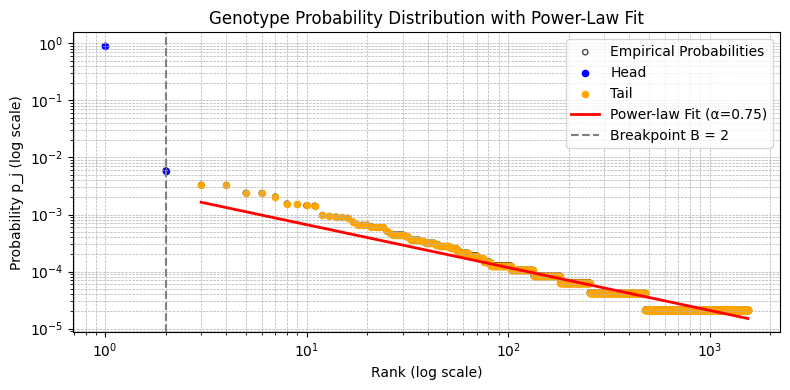

In [ ]:
plot_distribution(counts, results)